In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from pathlib import Path
import sys
import matplotlib.pyplot as plt


In [2]:
BASE_PATH = Path.cwd().parent
TESTING_FILES_BASE_PATH = BASE_PATH/"testing"/"files"
sys.path.append(str(BASE_PATH))

In [3]:
from model.main import EMOTIONS

def plot_beliefs(belief_user, belief_character, belief_user_character):
    x = np.arange(len(EMOTIONS))
    width = 0.25  # Slightly smaller width to fit 3 bars

    label1 = "System's belief about User"
    label2 = "System's belief about other character"
    label3 = "System's belief about User's belief about other character"

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, belief_user, width, label=label1)
    bars2 = ax.bar(x, belief_character, width, label=label2)
    bars3 = ax.bar(x + width, belief_user_character, width, label=label3)

    ax.set_xlabel('Mental States')
    ax.set_ylabel('Probability')
    ax.set_title('Belief Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(EMOTIONS)
    ax.legend()

    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

c:\Users\dchal\Documents\GitHub\GDRR_Research_LLMs_ToM


In [4]:
# Entropy: using log base 2
def entropy(dist):
    dist = np.array(dist)
    dist = dist[dist > 0]  # Avoid log(0)
    return -np.sum(dist * np.log2(dist))

In [5]:
# Takes data from neg_correlation_emotions, pos_correlation_emotions and uncorrelated_emotions distributions
# Generates stats on distribution divergence (Jensen-Shannon divergence) 
class TestCaseDivergence():
    # Read files and generate stats
    def __init__(self, folder_path_dists, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.System_beliefs_user = [] # dist 1: System's belief of User
        self.System_beliefs_character = [] # dist 2: System's belief of other character
        self.System_beliefs_users_belief_character = [] # dist 3: System's belief of User's belief of other character
        self.jsds_1_2 = []
        self.jsds_1_3 = []
        self.jsds_2_3 = []

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_dists/("message_"+str(i+1)+"_belief_dist.csv"))
            self.System_beliefs_user.append(df["Prob_System_belief_User"])
            self.System_beliefs_character.append(df["Prob_System_belief_Character"])
            self.System_beliefs_users_belief_character.append(df["Prob_System_belief_User_belief_Character"])

            # Jensen-Shannon Divergences
            jsd_1_2 = jensenshannon(df["Prob_System_belief_User"], df["Prob_System_belief_Character"])
            self.jsds_1_2.append(jsd_1_2)

            jsd_1_3 = jensenshannon(df["Prob_System_belief_User"], df["Prob_System_belief_User_belief_Character"])
            self.jsds_1_3.append(jsd_1_3)

            jsd_2_3 = jensenshannon(df["Prob_System_belief_Character"], df["Prob_System_belief_User_belief_Character"])
            self.jsds_2_3.append(jsd_2_3)
            
    def display_stats(self):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.System_beliefs_user[i], self.System_beliefs_character[i], self.System_beliefs_users_belief_character[i])
            print("JSD - between System's belief of User & System's belief of other character: ", self.jsds_1_2[i])
            
            print("JSD - between System's belief of User & System's belief of User's belief of other character: ", self.jsds_1_3[i])
            
            print("JSD - between System's belief of Other character & System's belief of User's belief of other character: ", self.jsds_2_3[i])
            

In [6]:
# Takes data from user_emotions_explicit_character_emotions_explicit,
#                 user_emotions_explicit_character_emotions_implicit,
#                 user_emotions_implicit_character_emotions_explicit,
#                 user_emotions_implicit_character_emotions_implicit,
# Generates stats on entropy
class TestCaseEntropy():
    # Read files and generate stats
    def __init__(self, folder_path_dists, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.System_beliefs_user = [] # dist 1: System's belief of User
        self.System_beliefs_character = [] # dist 2: System's belief of other character
        self.System_beliefs_users_belief_character = [] # dist 3: System's belief of User's belief of other character
        self.entropies_1 = [] # Entropy of dist 1
        self.entropies_2 = [] # Entropy of dist 2
        self.entropies_3 = [] # Entropy of dist 3

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_dists/("message_"+str(i+1)+"_belief_dist.csv"))
            self.System_beliefs_user.append(df["Prob_System_belief_User"])
            self.System_beliefs_character.append(df["Prob_System_belief_Character"])
            self.System_beliefs_users_belief_character.append(df["Prob_System_belief_User_belief_Character"])

            self.entropies_1.append(entropy(df["Prob_System_belief_User"]))
            self.entropies_2.append(entropy(df["Prob_System_belief_Character"]))
            self.entropies_3.append(entropy(df["Prob_System_belief_User_belief_Character"]))


    def display_stats(self):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.System_beliefs_user[i], self.System_beliefs_character[i], self.System_beliefs_users_belief_character[i])
            print("Entropy - System's belief of User: ", self.entropies_1[i])
            print("Entropy - System's belief of other character: ", self.entropies_2[i])
            print("Entropy - System's belief of User's belief of other character: ", self.entropies_3[i])
            

Get and display all results individually

JENSON-SHANNON DIVERGENCE STATS 


Uncorrelated: 


------------------------------------------------------------------
1-User message: My coworker Jessica constantly takes credit for my ideas in meetings. I’m not sure how to call it out without sounding petty. What should I do?


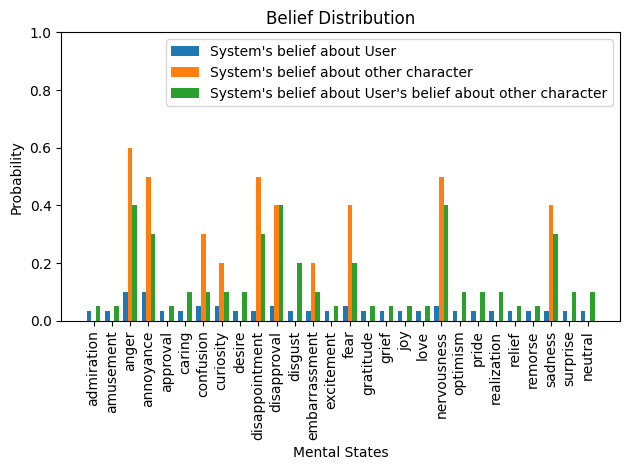

JSD - between System's belief of User & System's belief of other character:  0.49553651278808875
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2133885003030102
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.38309507630945205

------------------------------------------------------------------
2-User message: There’s a guy on my team, Mark, who always interrupts me when I’m talking. It’s gotten to the point where I dread speaking up. How do I handle this?


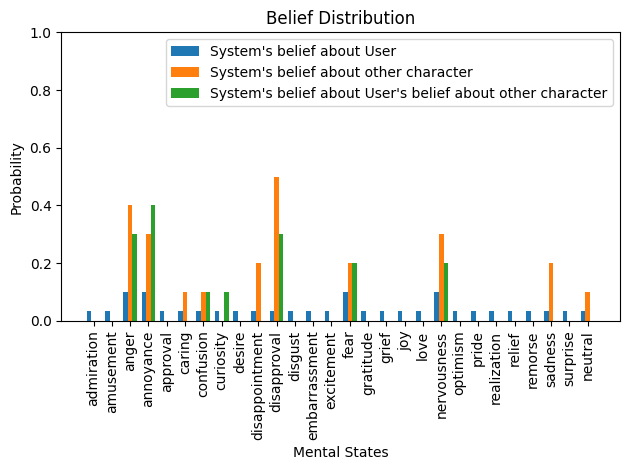

JSD - between System's belief of User & System's belief of other character:  0.49479962384989756
JSD - between System's belief of User & System's belief of User's belief of other character:  0.5343934671407838
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.3502140912907028

------------------------------------------------------------------
3-User message: My manager Ethan keeps messaging me after hours, even though we agreed on boundaries. I don’t want to seem uncooperative, but I’m burning out. Any advice?


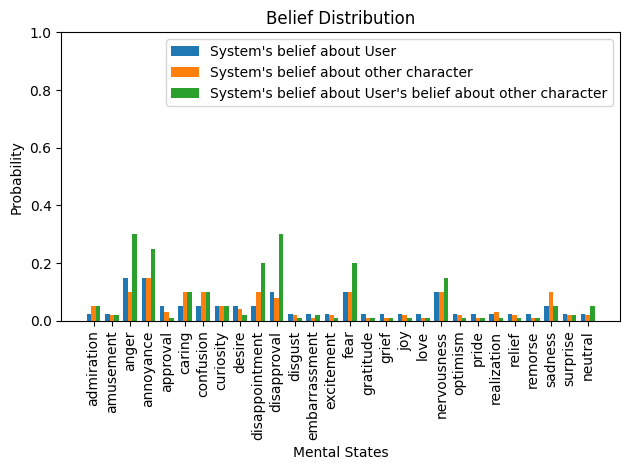

JSD - between System's belief of User & System's belief of other character:  0.16082736164447445
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2346000652184479
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.2129538459052408

------------------------------------------------------------------
4-User message: I have a teammate, Tina, who never pulls her weight on group projects, and I end up covering for her. How can I address it without creating tension?


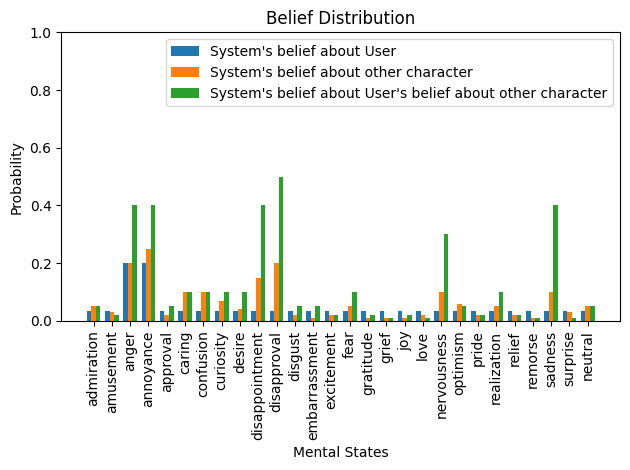

JSD - between System's belief of User & System's belief of other character:  0.25384466859560045
JSD - between System's belief of User & System's belief of User's belief of other character:  0.3358739032427373
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.16523482179866328

------------------------------------------------------------------
5-User message: One of my coworkers, Daniel, makes passive-aggressive comments about how I got my position. It’s subtle, but it’s getting under my skin. How do I respond?


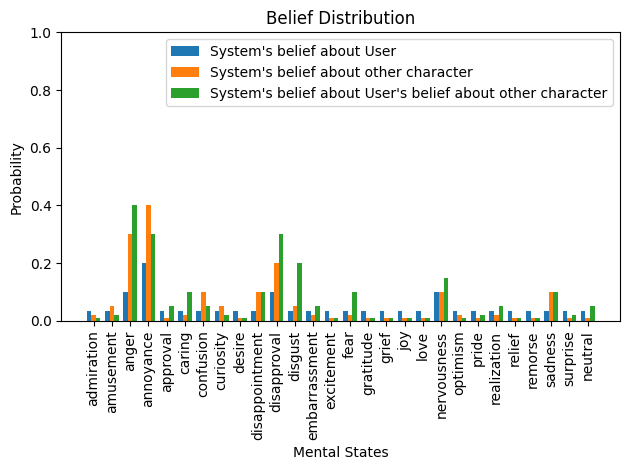

JSD - between System's belief of User & System's belief of other character:  0.2819244288913831
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2885090019801776
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.2154683508683606

------------------------------------------------------------------
6-User message: There's a person in my department, Rachel, who always finds a way to one-up everyone, even in casual conversations. It's exhausting. How can I deal with this tactfully?


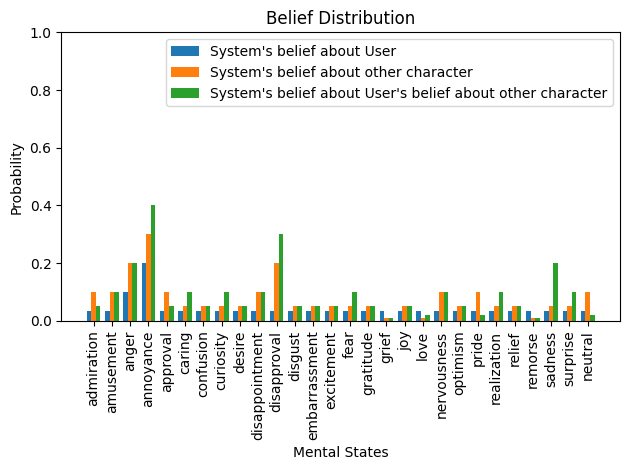

JSD - between System's belief of User & System's belief of other character:  0.18297923193388194
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2216752172278194
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.19101066750090512

------------------------------------------------------------------
7-User message: My direct report Alex is great at their job but speaks to me in a very dismissive tone. I don’t want to micromanage, but it’s starting to affect how I lead. Thoughts?


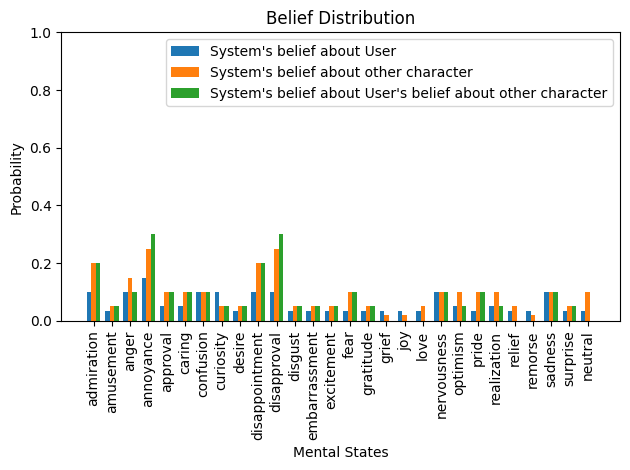

JSD - between System's belief of User & System's belief of other character:  0.1489170135896602
JSD - between System's belief of User & System's belief of User's belief of other character:  0.26137962067408305
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.20301702713441866

------------------------------------------------------------------
8-User message: A colleague, Lena, has started gossiping about me, and it's impacting how others treat me. I'm not sure if I should confront her or go to HR. What’s the best move?


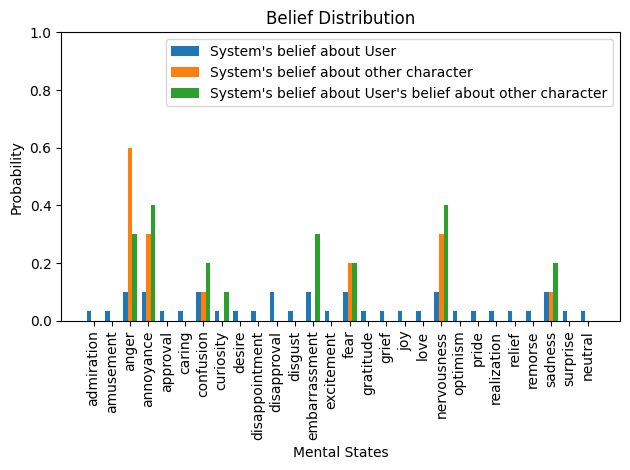

JSD - between System's belief of User & System's belief of other character:  0.5513516218944261
JSD - between System's belief of User & System's belief of User's belief of other character:  0.47979563707414236
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.3121257177527042

------------------------------------------------------------------
9-User message: There's one coworker, Jake, who constantly flirts with me even after I’ve tried to steer things back to professional topics. It’s making me uncomfortable. What should I do?


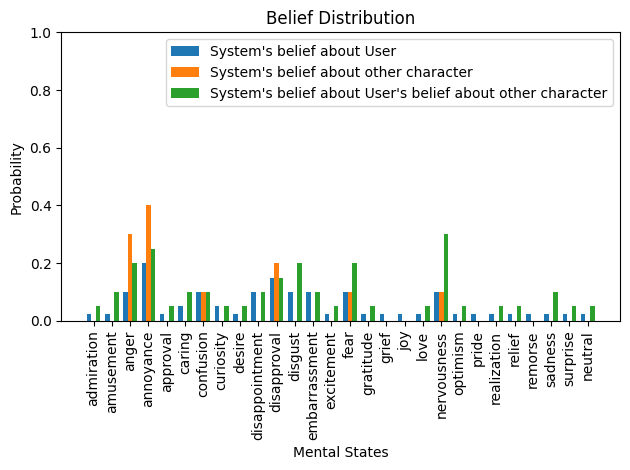

JSD - between System's belief of User & System's belief of other character:  0.49205975138647207
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2057019638099733
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.5049409212187445

------------------------------------------------------------------
10-User message: My teammate Carlos keeps missing deadlines and giving excuses, and it's dragging down our whole timeline. I’ve tried nudging him gently, but nothing’s changed. What else can I try?


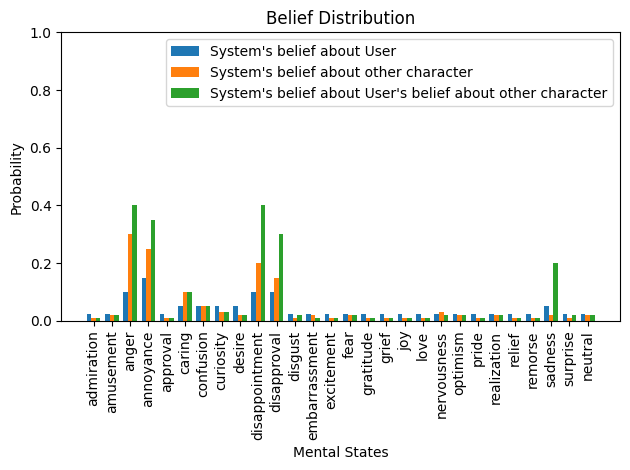

JSD - between System's belief of User & System's belief of other character:  0.2373216748694359
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2854537309562064
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.16596419196579362
Positively correlated: 

Negatively correlated: 



In [7]:
DISTRIBUTIONS_BASE_PATH = TESTING_FILES_BASE_PATH/"distributions"
MESSAGES_BASE_PATH = TESTING_FILES_BASE_PATH/"messages"

# Divergence test cases
uncorrelated_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"uncorrelated_emotions", MESSAGES_BASE_PATH/"uncorrelated_emotions.txt")
pos_correlated_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"pos_correlated_emotions", MESSAGES_BASE_PATH/"pos_correlated_emotions.txt")
neg_correlated_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"neg_correlated_emotions", MESSAGES_BASE_PATH/"neg_correlated_emotions.txt")

# Display individual message stats
print("JENSON-SHANNON DIVERGENCE STATS \n\n")

print("Uncorrelated: \n")
uncorrelated_test_case.display_stats()
print("Positively correlated: \n")
#pos_correlated_test_case.display_stats()
print("Negatively correlated: \n")
#neg_correlated_test_case.display_stats()


ENTROPY STATS 


User emotions explicit, other character emotions explicit: 


------------------------------------------------------------------
1-User message: Hi, I need some advice. My supervisor, Sarah, constantly second-guesses my work in meetings. I feel frustrated and embarrassed because it seems like she doesn't trust me. She's always calm and professional on the surface, but I sense a passive-aggressive tone in her corrections. I’m starting to feel anxious before every meeting. How should I approach this?


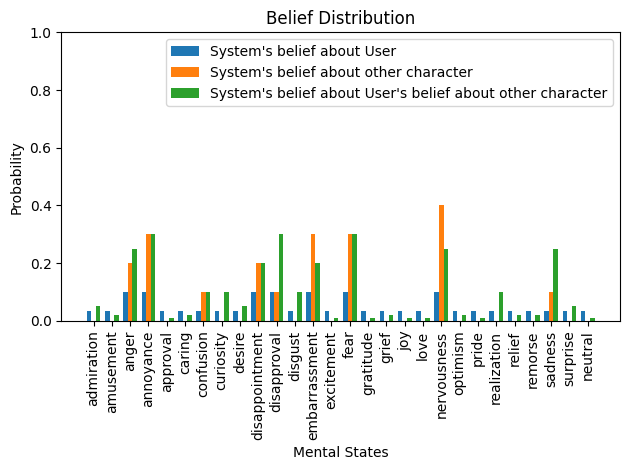

Entropy - System's belief of User:  5.930865857964353
Entropy - System's belief of other character:  4.017389939125684
Entropy - System's belief of User's belief of other character:  7.111433400949779

------------------------------------------------------------------
2-User message: Hi, I’ve noticed my coworker Tom has become really cold toward me ever since I got promoted. He used to be friendly, but now he avoids me and gives short, clipped responses. I feel guilty and uncomfortable, even though I worked hard for the promotion. He seems resentful. How do I fix this tension without making it worse?


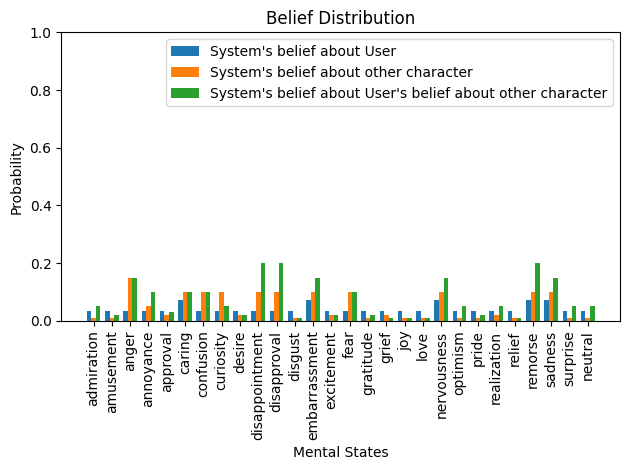

Entropy - System's belief of User:  5.308668300996459
Entropy - System's belief of other character:  5.243779138609355
Entropy - System's belief of User's belief of other character:  6.70903111899111

------------------------------------------------------------------
3-User message: I work closely with Amanda, and she’s always trying to take control of every task we’re assigned. She’s enthusiastic, but I feel overwhelmed and pushed aside. She gets impatient if I suggest a different approach. I’m starting to feel irritated and invisible. She seems driven but unaware of how she’s coming across. What can I do?


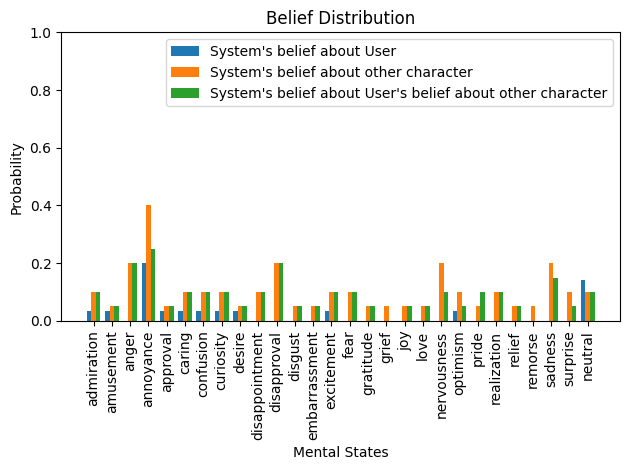

Entropy - System's belief of User:  2.4106575470756453
Entropy - System's belief of other character:  8.63359147517335
Entropy - System's belief of User's belief of other character:  7.870497433644024

------------------------------------------------------------------
4-User message: Hey, I need some help navigating this. I’m mentoring an intern named Jake, and while he’s friendly and eager, he’s way too casual—shows up late, calls me “bro,” and treats deadlines loosely. I feel disrespected and stressed out trying to keep him on track. He seems relaxed and clueless about how serious the work environment is. How do I address this?


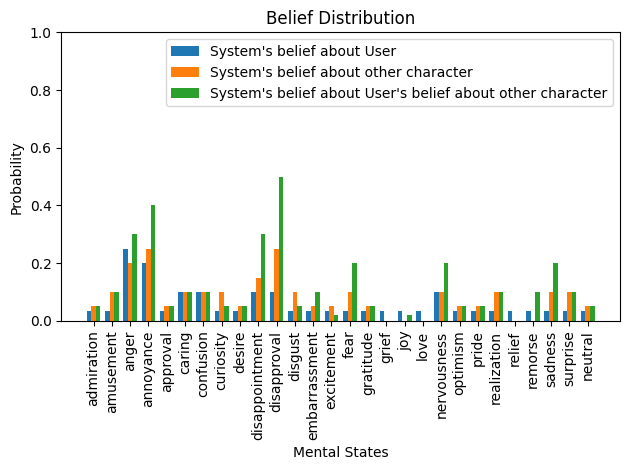

Entropy - System's belief of User:  6.230865857964353
Entropy - System's belief of other character:  7.14172619568908
Entropy - System's belief of User's belief of other character:  7.960079008098542

------------------------------------------------------------------
5-User message: Hi, I sit next to Carla, and she’s constantly chatting, humming, or playing videos out loud. She seems cheerful and completely unaware of how distracting she is. Meanwhile, I’m getting frustrated and falling behind on my work. I don’t want to come off as rude, but this is really affecting my focus. How can I bring this up without hurting her feelings?


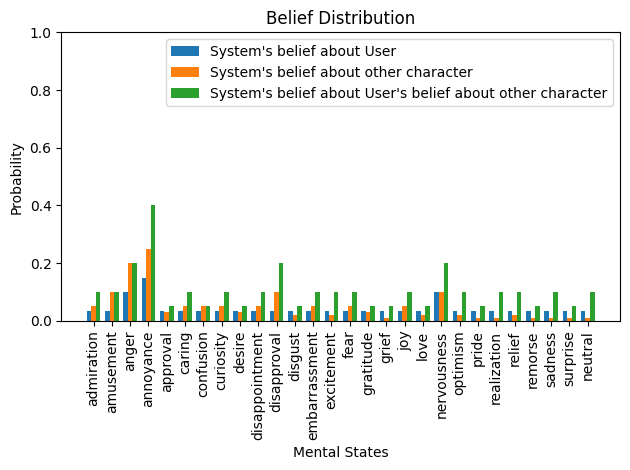

Entropy - System's belief of User:  5.367211638510975
Entropy - System's belief of other character:  5.174491269675152
Entropy - System's belief of User's belief of other character:  8.733591475173352

------------------------------------------------------------------
6-User message: My manager, Dave, checks in on my progress multiple times a day. He seems anxious and overly controlling. I feel stifled and not trusted, even though I always meet my deadlines. I think his stress is causing him to hover, but it’s really affecting my motivation. How do I set boundaries without damaging our working relationship?


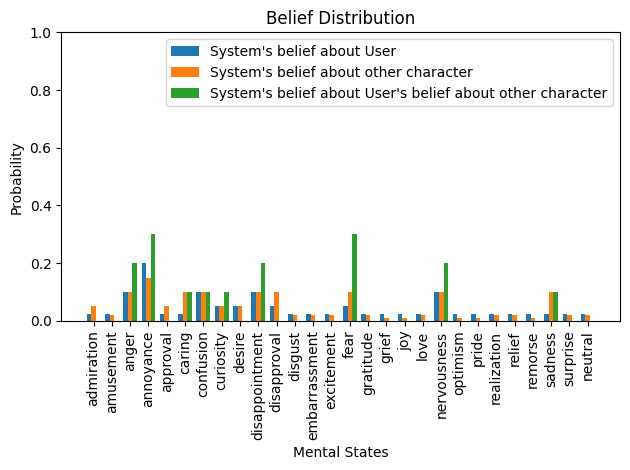

Entropy - System's belief of User:  5.185458320981388
Entropy - System's belief of other character:  5.3934369814559755
Entropy - System's belief of User's belief of other character:  3.7641074513870856

------------------------------------------------------------------
7-User message: I sit near someone named Ben who constantly complains—about the company, the projects, even the weather. He seems jaded and angry all the time. I used to try to cheer him up, but now I just feel drained and irritated. I’m starting to dread going into the office. Is there a way to deal with this without just avoiding him?


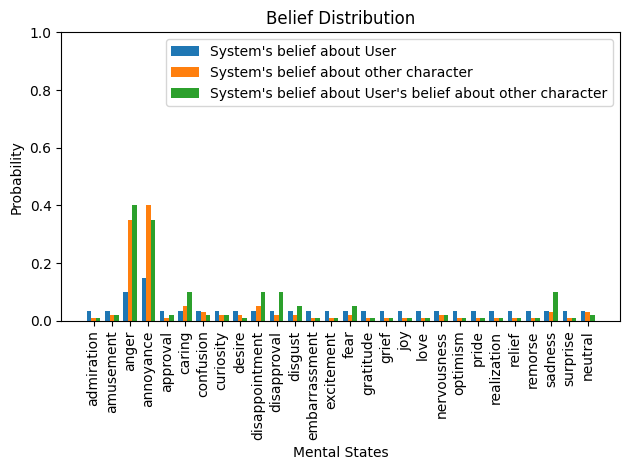

Entropy - System's belief of User:  5.206710076238582
Entropy - System's belief of other character:  3.66664482308584
Entropy - System's belief of User's belief of other character:  4.427238505230471

------------------------------------------------------------------
8-User message: My teammate Lily and I used to be really close, but lately she’s been distant—only talking to me when necessary and leaving me out of conversations she has with others. I feel hurt and confused, and she seems withdrawn and maybe even annoyed with me. I have no idea what changed. Should I confront her or give her space?


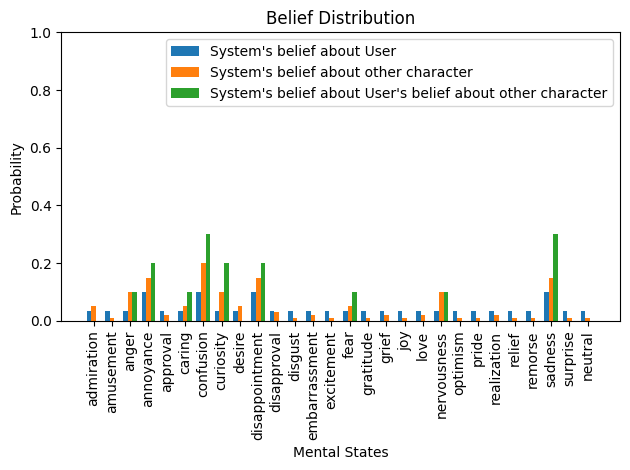

Entropy - System's belief of User:  5.449361171147174
Entropy - System's belief of other character:  5.003960794320247
Entropy - System's belief of User's belief of other character:  3.7641074513870865

------------------------------------------------------------------
9-User message: I’m struggling with a situation where Jordan, a peer on my team, has repeatedly taken credit for ideas I’ve shared in private conversations or emails. He acts confident and charming in front of others, but I feel betrayed and angry. I don’t want to seem petty, but this is making me feel invisible and disrespected. How should I handle this?


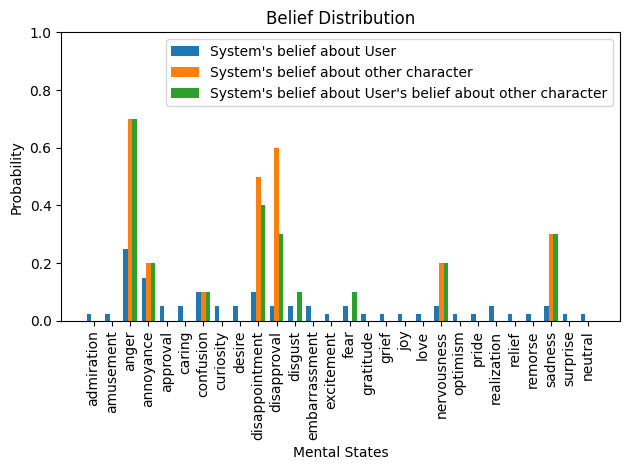

Entropy - System's belief of User:  5.681617541128847
Entropy - System's belief of other character:  3.0844343031740977
Entropy - System's belief of User's belief of other character:  3.856501481856653

------------------------------------------------------------------
10-User message: My supervisor, Karen, clearly favors one team member—Mike. She laughs at all his jokes, assigns him the most exciting tasks, and gives him way more praise than the rest of us. I feel discouraged and undervalued. She seems cheerful and unaware of how demotivating this is for the rest of us. Is there a professional way to address this?


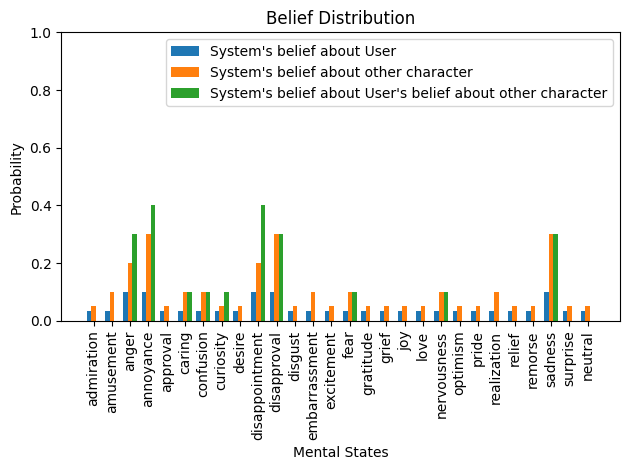

Entropy - System's belief of User:  5.609862733419567
Entropy - System's belief of other character:  8.274932415035574
Entropy - System's belief of User's belief of other character:  4.281775558103156
User emotions explicit, other character emotions implicit: 


------------------------------------------------------------------
1-User message: Hi, I’m feeling really frustrated and embarrassed lately. My supervisor, Sarah, keeps second-guessing my work during meetings, even when I’ve double-checked everything. She stays calm and professional, but her comments are often cutting and seem deliberately timed to make me look bad in front of others. It’s making me dread meetings and question my abilities. What should I do?


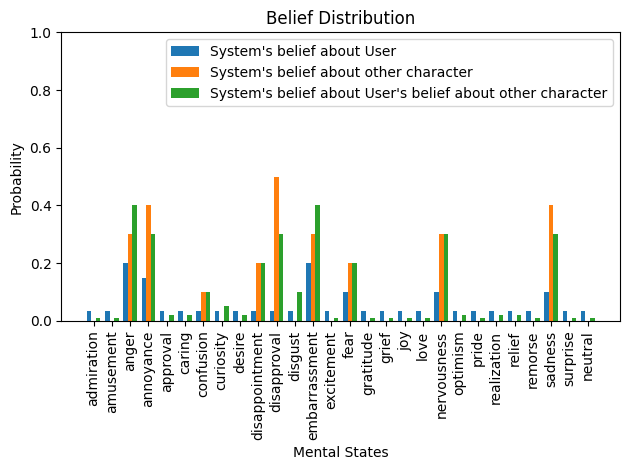

Entropy - System's belief of User:  6.113101944305628
Entropy - System's belief of other character:  4.381775558103157
Entropy - System's belief of User's belief of other character:  6.35924137423431

------------------------------------------------------------------
2-User message: I’m feeling incredibly uncomfortable and even a bit guilty. Since my recent promotion, my coworker Tom has become noticeably distant—he barely speaks to me and keeps things very formal now. We used to joke around and collaborate easily. The change is really bothering me, and it’s affecting how I feel at work. How do I handle this kind of shift in dynamics?


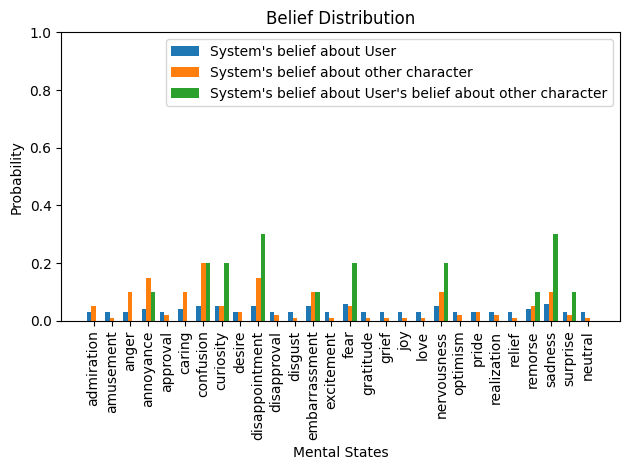

Entropy - System's belief of User:  4.856614601270164
Entropy - System's belief of other character:  5.2766912610489
Entropy - System's belief of User's belief of other character:  4.228493070364559

------------------------------------------------------------------
3-User message: Lately, I’ve been feeling overwhelmed and sidelined. I work closely with Amanda, and she always takes the lead, even on tasks we’re supposed to do together. She dismisses my input quickly and insists on doing things her way. Her energy is intense, and I feel like I’m constantly battling to be heard. How can I bring this up without starting conflict?


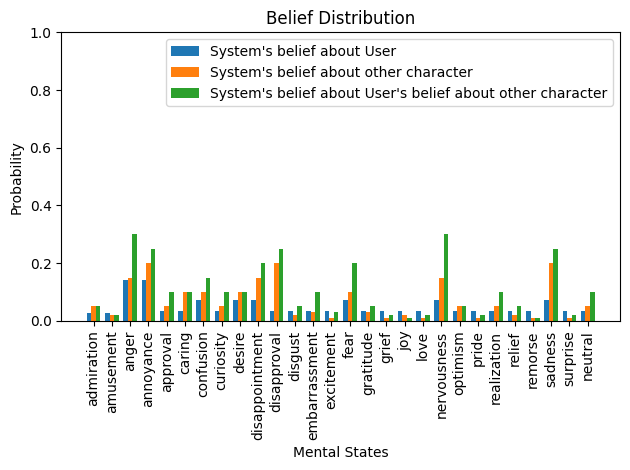

Entropy - System's belief of User:  5.8173692809036
Entropy - System's belief of other character:  6.403814528640041
Entropy - System's belief of User's belief of other character:  8.136356677167168

------------------------------------------------------------------
4-User message: I’m feeling drained and a bit disrespected. I’ve been mentoring Jake, a new intern, and while he’s friendly, he treats the whole experience like it’s a college group project—he’s late, uses super casual language, and ignores deadlines. He seems completely unaware of how serious the environment is, and I’m stuck trying to keep things on track. How can I reset expectations?


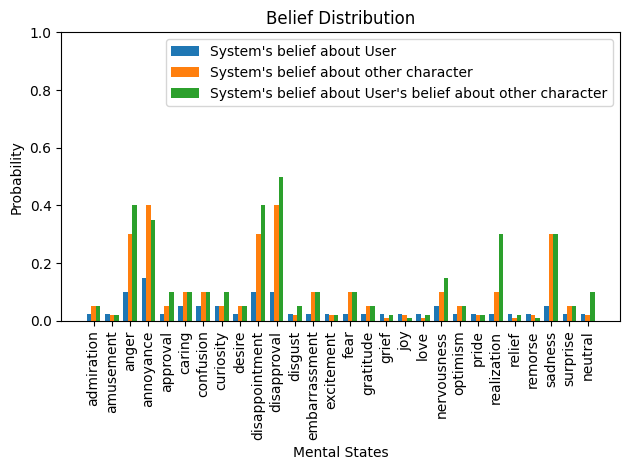

Entropy - System's belief of User:  5.015521136384479
Entropy - System's belief of other character:  7.116098753064173
Entropy - System's belief of User's belief of other character:  7.972435243480785

------------------------------------------------------------------
5-User message: I’m getting really irritated and mentally exhausted. Carla, who sits next to me, is always chatting, humming, or watching videos out loud. I can’t focus, and it’s starting to affect my productivity. She seems upbeat and doesn’t seem to notice how disruptive she is. I don’t want to come off as mean, but I really need some quiet. What’s the best way to bring this up?


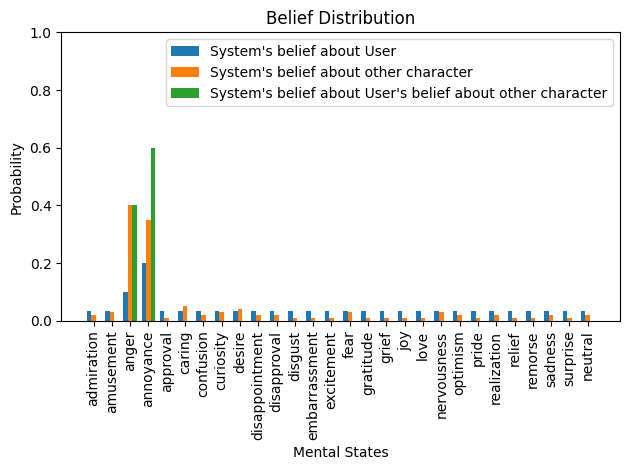

Entropy - System's belief of User:  5.260550856091124
Entropy - System's belief of other character:  3.768069476604068
Entropy - System's belief of User's belief of other character:  0.9709505944546686

------------------------------------------------------------------
6-User message: Honestly, I’m feeling stifled and tense all the time. My manager, Dave, checks in constantly—sometimes multiple times a day—to see how things are going. I always meet deadlines and keep things organized, but it feels like he doesn’t trust me to manage my own tasks. He’s always hovering, and it’s really wearing me down. How do I ask for more breathing room?


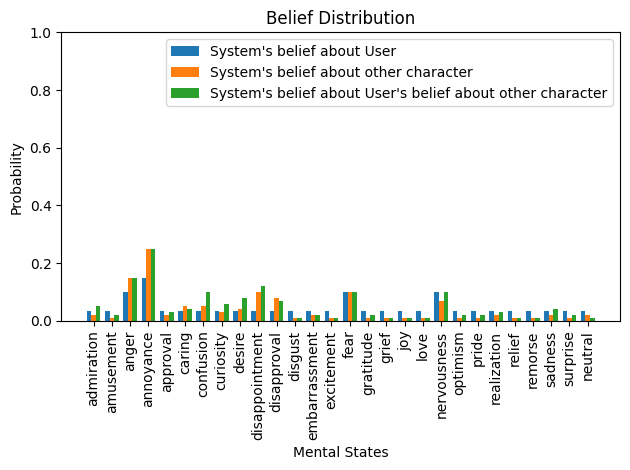

Entropy - System's belief of User:  5.527713200783368
Entropy - System's belief of other character:  4.379233395321847
Entropy - System's belief of User's belief of other character:  5.177697474767464

------------------------------------------------------------------
7-User message: I’m feeling emotionally drained and discouraged. Ben, who works nearby, is always complaining—about the company, our team, even the weather. His presence has become exhausting, and it’s starting to affect my mood and motivation. He vents constantly and doesn’t seem to realize how much of a cloud he brings into the space. What’s the best way to protect my energy?


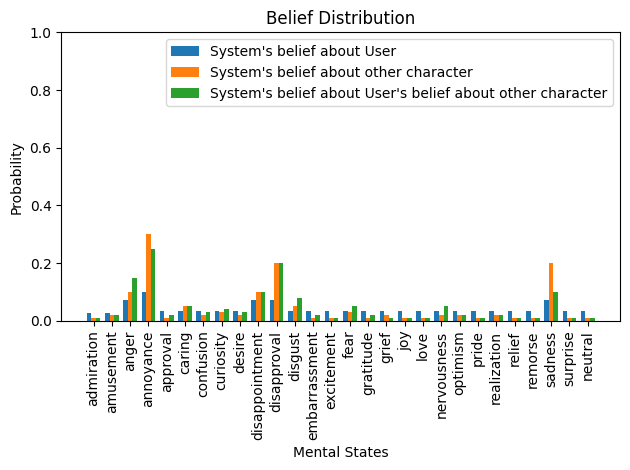

Entropy - System's belief of User:  5.318626579730964
Entropy - System's belief of other character:  4.437375575355659
Entropy - System's belief of User's belief of other character:  4.810050017179602

------------------------------------------------------------------
8-User message: I’m feeling hurt and confused. My colleague Lily and I used to be close, but recently she’s become distant—avoiding conversations, only speaking when necessary, and leaving me out of informal chats with others. It’s painful not knowing what caused this change, and I can’t stop wondering if I did something wrong. Should I bring it up or just give her space?


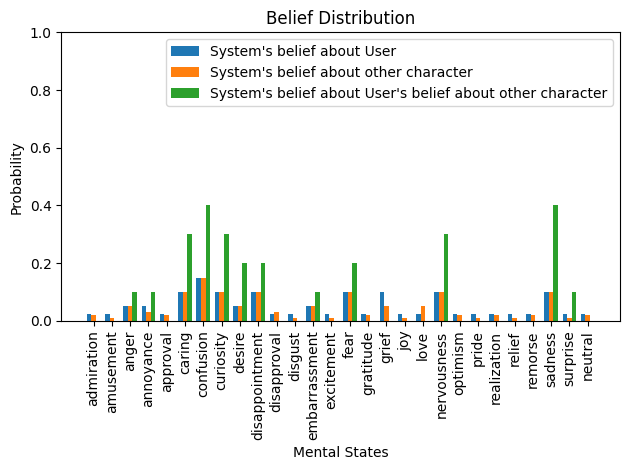

Entropy - System's belief of User:  5.729051362478503
Entropy - System's belief of other character:  5.042927140975097
Entropy - System's belief of User's belief of other character:  5.3427396055468375

------------------------------------------------------------------
9-User message: I’m feeling angry and deeply frustrated. Jordan, who’s on my team, has brought up ideas in meetings that I originally shared with him in one-on-one chats or emails—as if they were his. He presents things smoothly and confidently, and people don’t seem to realize those weren’t his contributions. I feel invisible and betrayed. How do I call this out without looking petty?


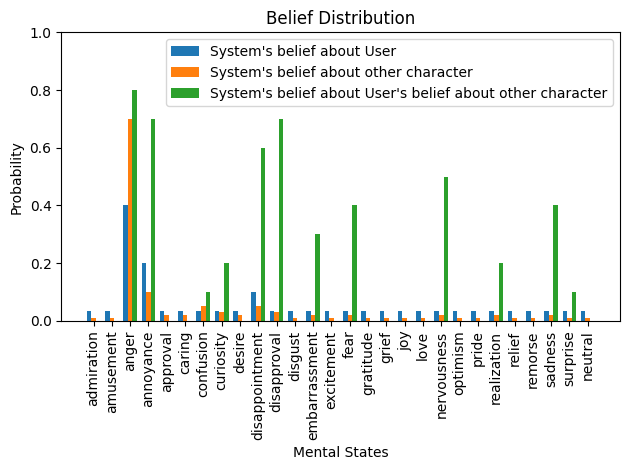

Entropy - System's belief of User:  5.617630846829725
Entropy - System's belief of other character:  3.2612773182339345
Entropy - System's belief of User's belief of other character:  5.091913285463444

------------------------------------------------------------------
10-User message: I’m feeling really demoralized and overlooked. My supervisor Karen always gives Mike the best projects, praises him constantly, and laughs at all his jokes. Meanwhile, the rest of us are barely acknowledged. She seems friendly and upbeat around him, but there’s a clear gap in how we’re treated. It’s killing my motivation. How can I address this without sounding bitter?


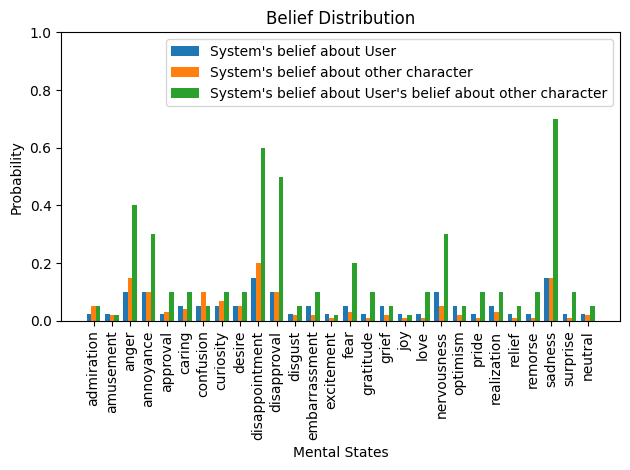

Entropy - System's belief of User:  5.824355189742515
Entropy - System's belief of other character:  5.048723946227603
Entropy - System's belief of User's belief of other character:  8.843143899885856
User emotions implicit, other character emotions explicit: 


------------------------------------------------------------------
1-User message: My supervisor, Sarah, often corrects me in meetings in a way that seems unnecessarily public. She maintains a very composed tone, but there's a sharpness to it that suggests she’s frustrated with my work or doesn’t trust me. I’ve noticed I start preparing excessively for meetings just to avoid those moments. What would be a good way to talk to her about this?


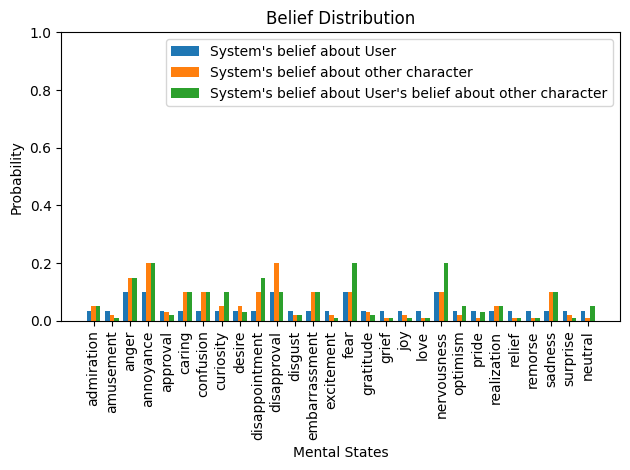

Entropy - System's belief of User:  5.6098627334195665
Entropy - System's belief of other character:  5.908479097981168
Entropy - System's belief of User's belief of other character:  6.245462499003846

------------------------------------------------------------------
2-User message: Since I got promoted, my colleague Tom has been acting resentful. He barely speaks to me now and avoids collaboration when we used to work really well together. He used to be easygoing, but now there’s a noticeable edge in his tone, and he’s clearly irritated during group discussions. How should I navigate this without making things more awkward?


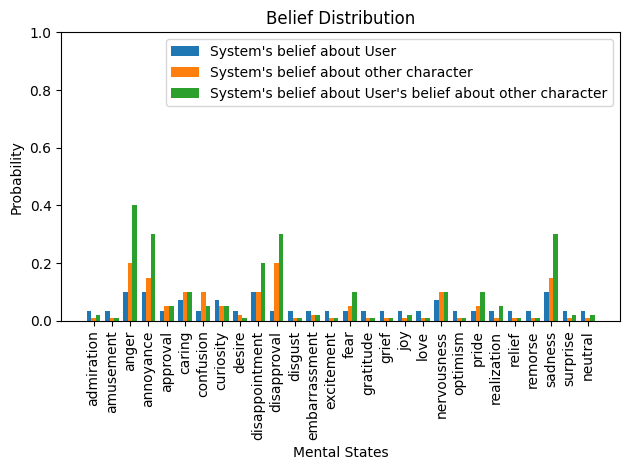

Entropy - System's belief of User:  5.7501491985104884
Entropy - System's belief of other character:  5.098911887296676
Entropy - System's belief of User's belief of other character:  5.978353986569366

------------------------------------------------------------------
3-User message: I work with Amanda, who’s extremely controlling about shared tasks. She gets impatient if I don’t agree with her approach right away and often insists on doing things herself. She’s clearly very determined and tends to get irritated when things aren’t done her way. I’m finding it harder to contribute meaningfully in our projects. How do I deal with this dynamic?


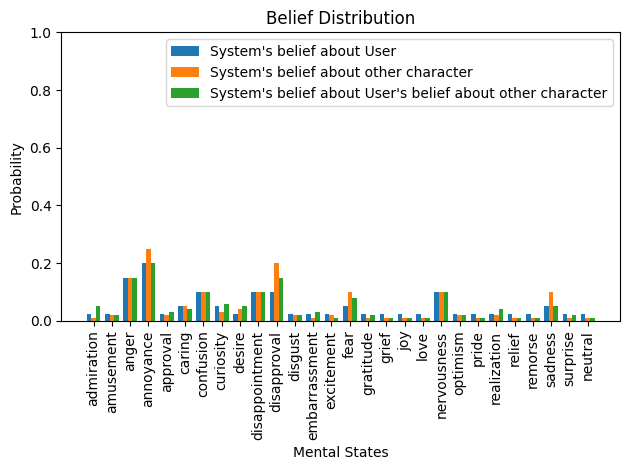

Entropy - System's belief of User:  5.462954957734135
Entropy - System's belief of other character:  4.997598892201236
Entropy - System's belief of User's belief of other character:  5.236321287136483

------------------------------------------------------------------
4-User message: I’ve been mentoring an intern, Jake, who’s a bit too relaxed about the job. He’s often late, uses overly casual language with everyone—including senior staff—and misses minor deadlines. He seems completely unconcerned, almost like he thinks it’s all part of the learning curve. I’m not sure how to get him to take things more seriously without coming off too harsh.


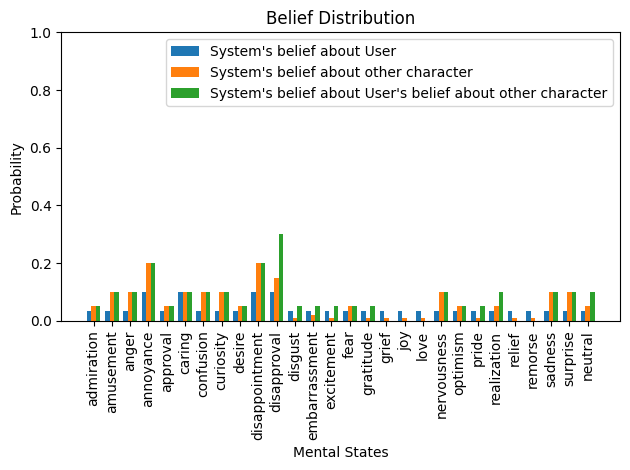

Entropy - System's belief of User:  5.449361171147173
Entropy - System's belief of other character:  6.220357567075563
Entropy - System's belief of User's belief of other character:  6.932753058535852

------------------------------------------------------------------
5-User message: Carla, who sits next to me, is constantly talking, humming, or playing videos aloud while she works. She’s in a great mood most of the time—very upbeat and chatty—which I think makes her unaware of how distracting she can be. I find myself moving to other spaces just to get things done. What’s a respectful way to bring this up?


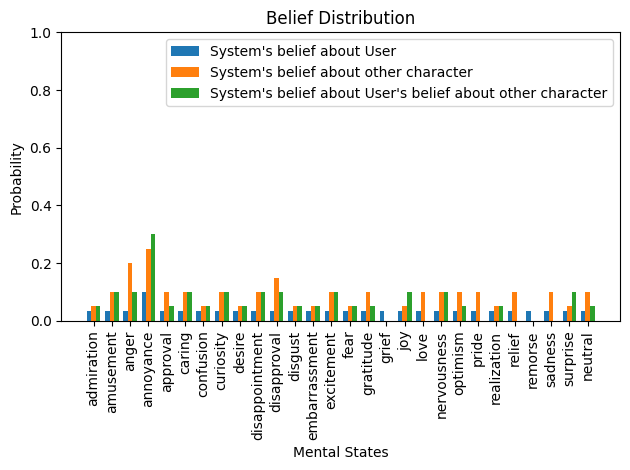

Entropy - System's belief of User:  4.967856484329993
Entropy - System's belief of other character:  7.970497433644025
Entropy - System's belief of User's belief of other character:  6.220078225325275

------------------------------------------------------------------
6-User message: Dave, my manager, checks in multiple times a day even when things are going smoothly. He seems anxious and preoccupied with making sure every task is accounted for. He’s not hostile or rude—just extremely hands-on, to the point that I feel like I don’t have space to make decisions on my own. How do I ask for more autonomy without upsetting him?


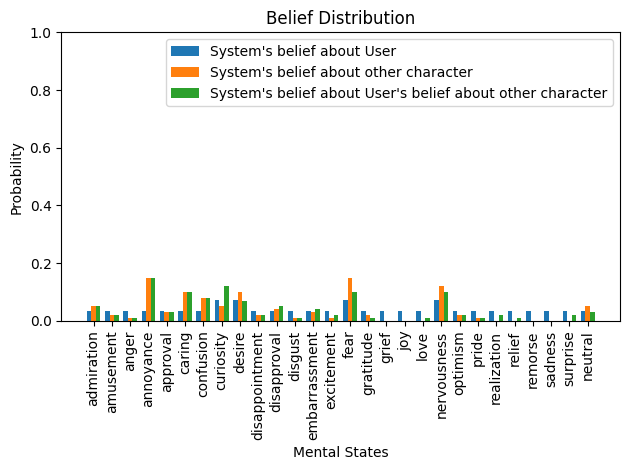

Entropy - System's belief of User:  5.2084056252086866
Entropy - System's belief of other character:  3.9988908610360148
Entropy - System's belief of User's belief of other character:  4.331628886782134

------------------------------------------------------------------
7-User message: I share a space with Ben, who’s constantly venting. He’s angry at leadership, annoyed with team processes, and even grumbles about minor issues like the coffee. He’s clearly disillusioned and bitter, and it colors every conversation. I’ve stopped engaging as much during breaks just to avoid getting pulled into it. How do I handle this professionally?


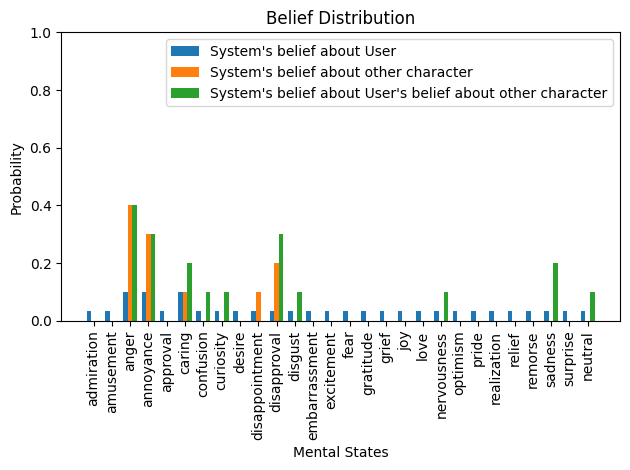

Entropy - System's belief of User:  5.28885960887478
Entropy - System's belief of other character:  2.178632154159752
Entropy - System's belief of User's belief of other character:  4.160685879853295

------------------------------------------------------------------
8-User message: Lily and I used to be close, but lately she’s grown distant. She seems irritated whenever I start a conversation and avoids eye contact or group chats when I’m around. It’s a big change from how things were just a few weeks ago, and her silence makes it hard to know what she’s feeling. I’m unsure if I should ask directly or leave it alone.


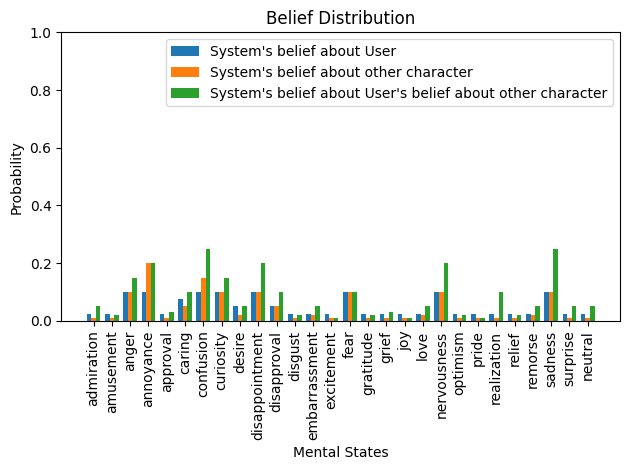

Entropy - System's belief of User:  5.631827145288223
Entropy - System's belief of other character:  4.681928486273998
Entropy - System's belief of User's belief of other character:  7.122927532361729

------------------------------------------------------------------
9-User message: Jordan has been presenting ideas in meetings that I originally discussed with him privately or shared over email. He sounds very confident and seems proud when he brings them up—there’s no hesitation or acknowledgment. It’s clear he wants the recognition and sees this as a way to stand out. How do I address this without looking confrontational?


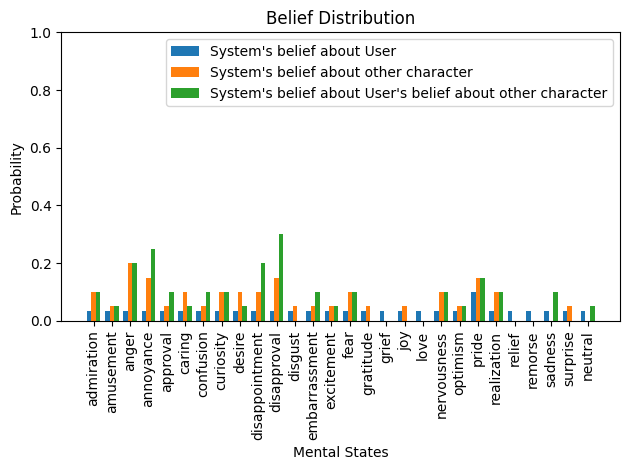

Entropy - System's belief of User:  4.967856484329993
Entropy - System's belief of other character:  6.514526659705837
Entropy - System's belief of User's belief of other character:  6.646719469194574

------------------------------------------------------------------
10-User message: Karen, my supervisor, clearly favors Mike. She’s enthusiastic when speaking with him, gives him the best assignments, and publicly praises him more than anyone else on the team. She seems genuinely delighted by his work, even when the rest of us contribute just as much. The disparity is hard to ignore. What’s a reasonable way to approach this?


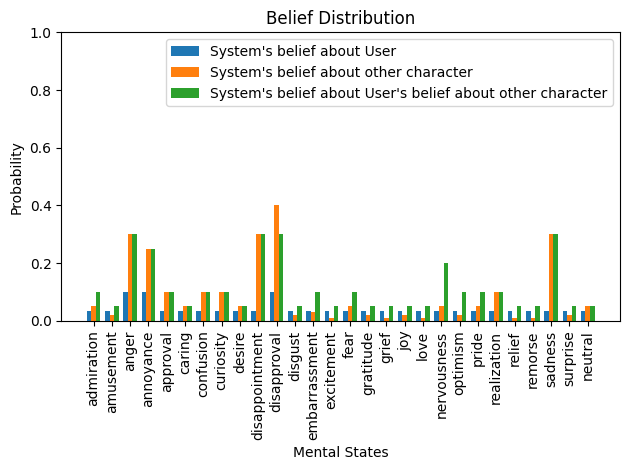

Entropy - System's belief of User:  5.28885960887478
Entropy - System's belief of other character:  6.594708706803363
Entropy - System's belief of User's belief of other character:  8.84773287905233
User emotions implicit, other character emotions implicit: 


------------------------------------------------------------------
1-User message: During meetings, my supervisor Sarah frequently comments on my work in front of others, often questioning small details I thought were resolved. Even when I’ve done my prep, she’ll bring up points that cast doubt on the quality of my work. These moments have become a regular pattern, and I’m trying to understand the best way to address it professionally.


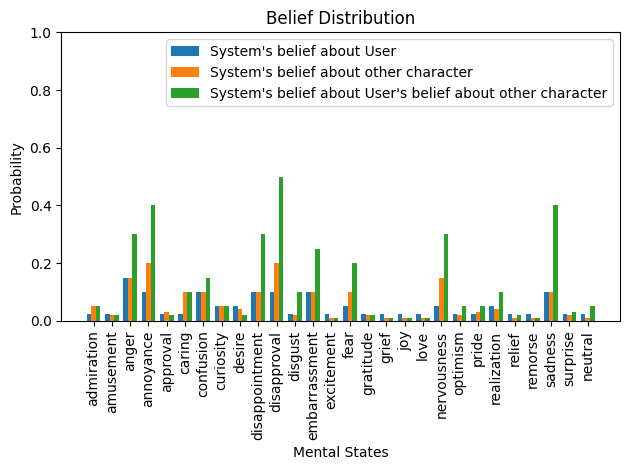

Entropy - System's belief of User:  5.612954957734136
Entropy - System's belief of other character:  5.879708251412857
Entropy - System's belief of User's belief of other character:  7.621147660087744

------------------------------------------------------------------
2-User message: Since I was promoted, Tom has been keeping his interactions with me brief and professional. We used to talk more casually and collaborate closely, but lately he sticks to work-only conversations and rarely joins group discussions when I’m present. The shift in our dynamic has been noticeable, and I’m not sure how to move forward.


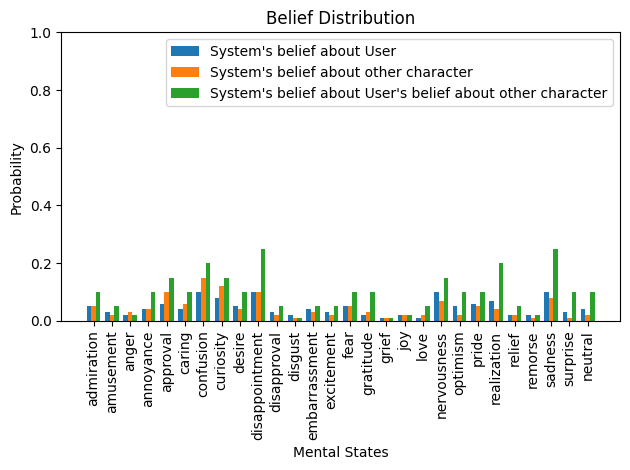

Entropy - System's belief of User:  5.400511783159869
Entropy - System's belief of other character:  5.07521853303006
Entropy - System's belief of User's belief of other character:  8.250420773865287

------------------------------------------------------------------
3-User message: Amanda and I are assigned to a number of joint projects. She often takes the lead without checking in and tends to move ahead with decisions before we’ve discussed things fully. When I offer suggestions, they’re often quickly dismissed or set aside. It’s made it hard for me to contribute the way I’d like to. I’m looking for advice on how to handle this constructively.


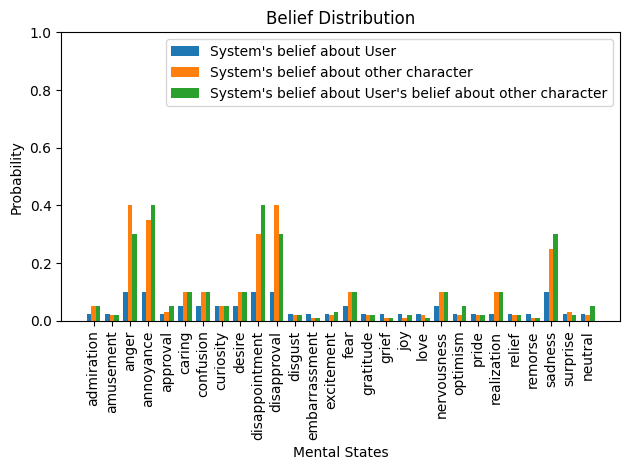

Entropy - System's belief of User:  5.219361916237021
Entropy - System's belief of other character:  6.6192644141649755
Entropy - System's belief of User's belief of other character:  6.902111316144792

------------------------------------------------------------------
4-User message: I’ve been mentoring an intern, Jake, who often shows up late, speaks to everyone informally, and isn’t always consistent with meeting small deadlines. I’ve tried giving him guidance, but things haven’t really changed. I’m looking for ways to help him adjust to the expectations of the workplace without making things uncomfortable.


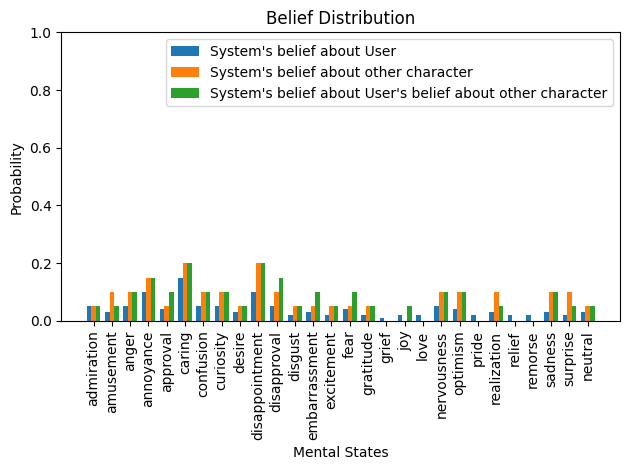

Entropy - System's belief of User:  4.921705169428421
Entropy - System's belief of other character:  6.606111814666553
Entropy - System's belief of User's belief of other character:  6.900560249047115

------------------------------------------------------------------
5-User message: Carla, who sits nearby, regularly plays videos out loud, hums, and starts casual conversations throughout the day. It’s a lively environment when she’s around, but I’ve found myself seeking quieter spots to work. I’m trying to find a respectful way to bring this up that doesn’t create tension.


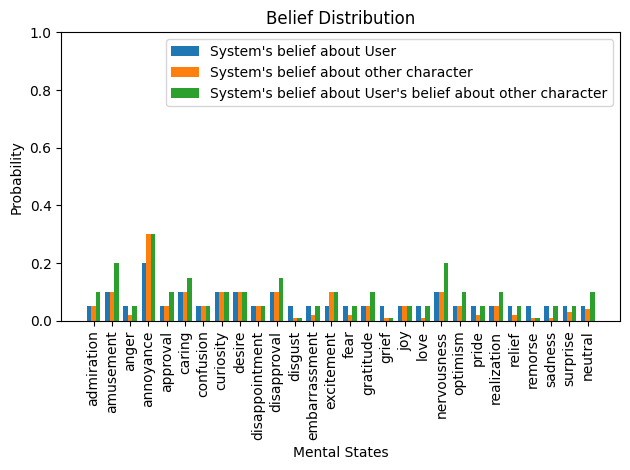

Entropy - System's belief of User:  6.995566975541621
Entropy - System's belief of other character:  5.809310069354766
Entropy - System's belief of User's belief of other character:  7.837062017734587

------------------------------------------------------------------
6-User message: My manager, Dave, checks in multiple times a day and frequently asks for updates on tasks that haven’t changed since the previous check-in. Even with a track record of completing work on time, I find myself being closely monitored. I’m not sure how to raise this in a way that leads to more independence while maintaining trust.


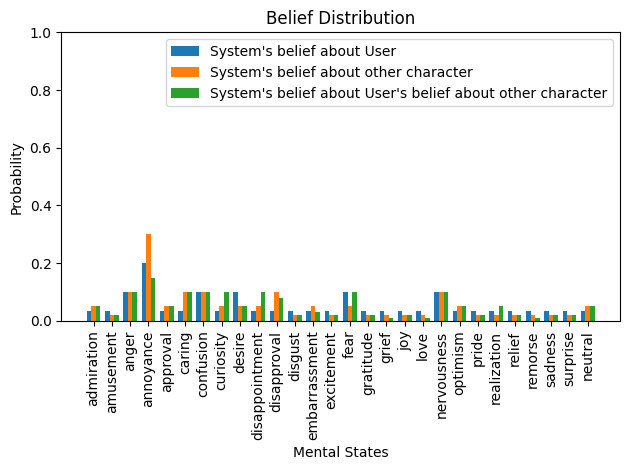

Entropy - System's belief of User:  5.902557105180696
Entropy - System's belief of other character:  5.594323977734287
Entropy - System's belief of User's belief of other character:  5.690958039718572

------------------------------------------------------------------
7-User message: I work near Ben, who often makes negative comments about the company, coworkers, and general day-to-day issues. These conversations happen regularly, and they tend to shift the tone of the room. I’ve started spending more time at my desk and avoiding communal areas. I’d appreciate suggestions for navigating this without creating conflict.


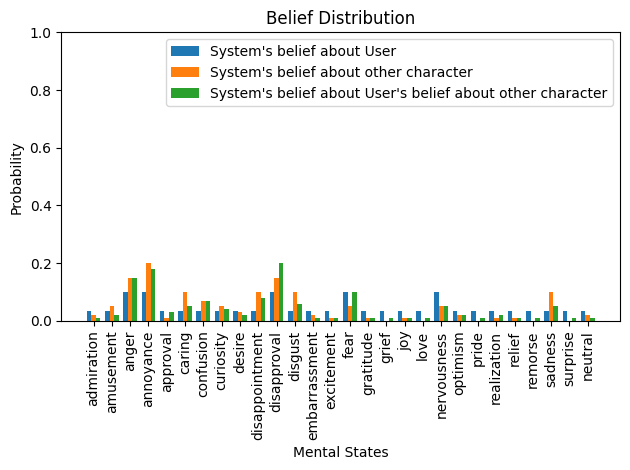

Entropy - System's belief of User:  5.6098627334195665
Entropy - System's belief of other character:  4.74909392014002
Entropy - System's belief of User's belief of other character:  4.69060959720701

------------------------------------------------------------------
8-User message: Lily and I used to talk often, both about work and things outside of it. Over the past couple of weeks, she’s been more distant—keeping conversations short and rarely making time to chat. She often leaves me out of group interactions that we used to participate in together. I’m unsure whether to bring it up or let it play out.


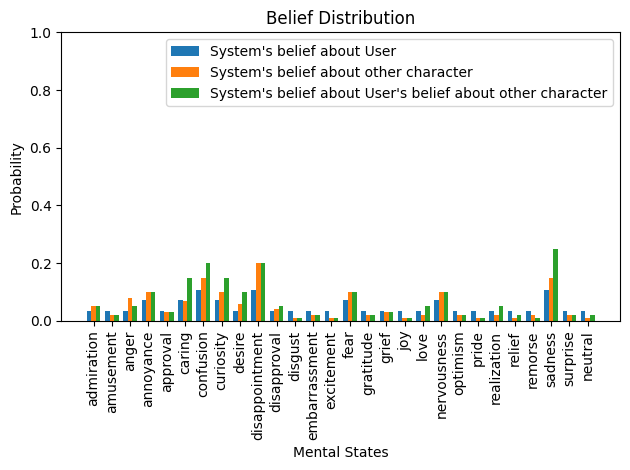

Entropy - System's belief of User:  5.829363551919859
Entropy - System's belief of other character:  5.424876375876682
Entropy - System's belief of User's belief of other character:  6.084980475282006

------------------------------------------------------------------
9-User message: On a few occasions, Jordan has shared ideas in meetings that were first discussed privately between us or that I outlined in team emails. He presents them confidently, and there’s usually no mention of our prior conversations. It’s been difficult to know how to respond in the moment. What’s the best way to handle this without escalating things?


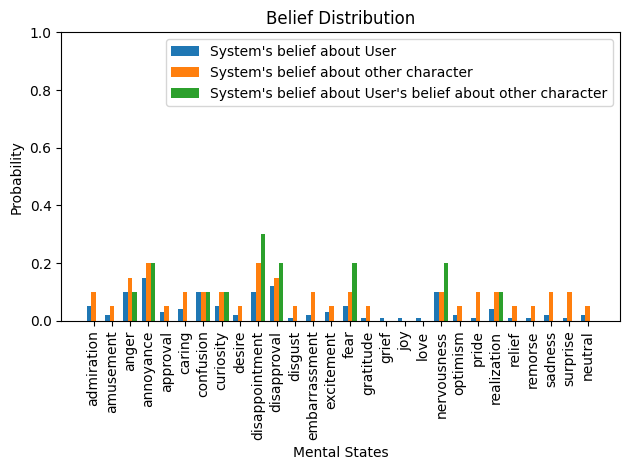

Entropy - System's belief of User:  4.704924450377295
Entropy - System's belief of other character:  7.564945868024587
Entropy - System's belief of User's belief of other character:  3.7074033921146965

------------------------------------------------------------------
10-User message: Karen often gives Mike the more visible and strategic assignments and publicly recognizes his contributions in meetings. He’s regularly included in early planning stages that the rest of us only hear about later. The pattern has been consistent, and it’s starting to affect how our team works together. I’m considering whether it’s worth raising this or not.


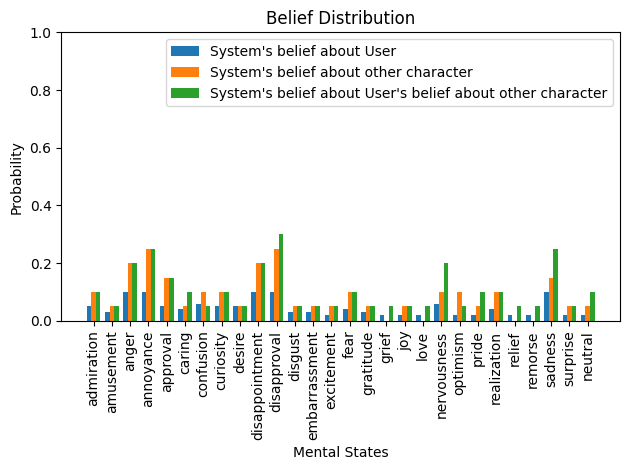

Entropy - System's belief of User:  5.305518132521923
Entropy - System's belief of other character:  7.45227103481401
Entropy - System's belief of User's belief of other character:  8.675490707149518


In [8]:

# Entropy test cases
user_exp_character_exp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_explicit_character_emotions_explicit", MESSAGES_BASE_PATH/"user_emotions_explicit_character_emotions_explicit.txt")
user_exp_character_imp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_explicit_character_emotions_implicit", MESSAGES_BASE_PATH/"user_emotions_explicit_character_emotions_implicit.txt")
user_imp_character_exp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_implicit_character_emotions_explicit", MESSAGES_BASE_PATH/"user_emotions_implicit_character_emotions_explicit.txt")
user_imp_character_imp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_implicit_character_emotions_implicit", MESSAGES_BASE_PATH/"user_emotions_implicit_character_emotions_implicit.txt")

# Display individual message stats
print("ENTROPY STATS \n\n")

print("User emotions explicit, other character emotions explicit: \n")
user_exp_character_exp_test_case.display_stats()

print("User emotions explicit, other character emotions implicit: \n")
user_exp_character_imp_test_case.display_stats()

print("User emotions implicit, other character emotions explicit: \n")
user_imp_character_exp_test_case.display_stats()

print("User emotions implicit, other character emotions implicit: \n")
user_imp_character_imp_test_case.display_stats()

High level overview

C:\Users\dchal\AppData\Local\Temp\ipykernel_25364\1218266346.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


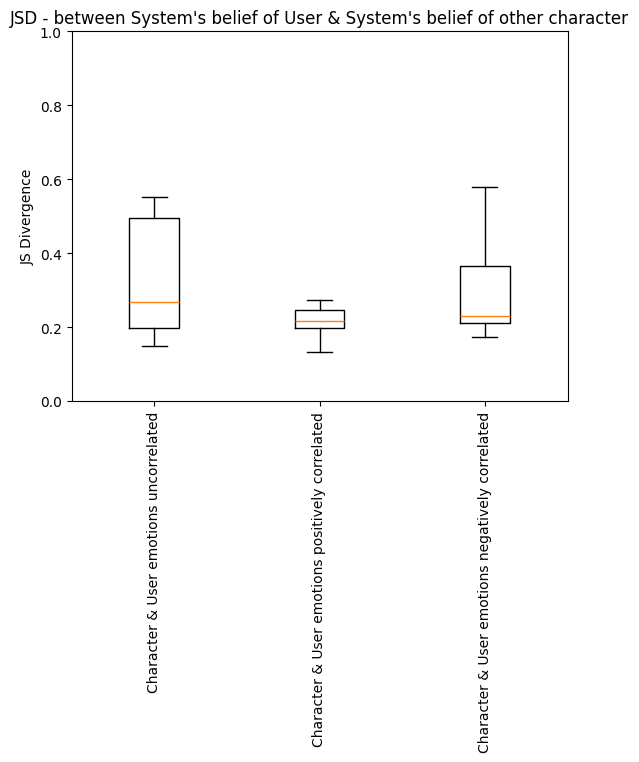

C:\Users\dchal\AppData\Local\Temp\ipykernel_25364\1218266346.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


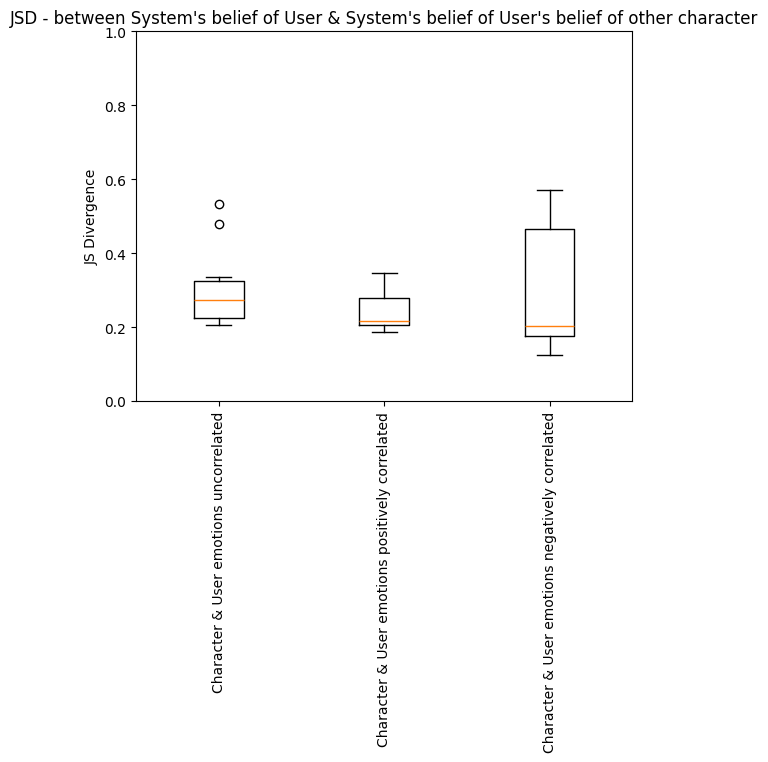

C:\Users\dchal\AppData\Local\Temp\ipykernel_25364\1218266346.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


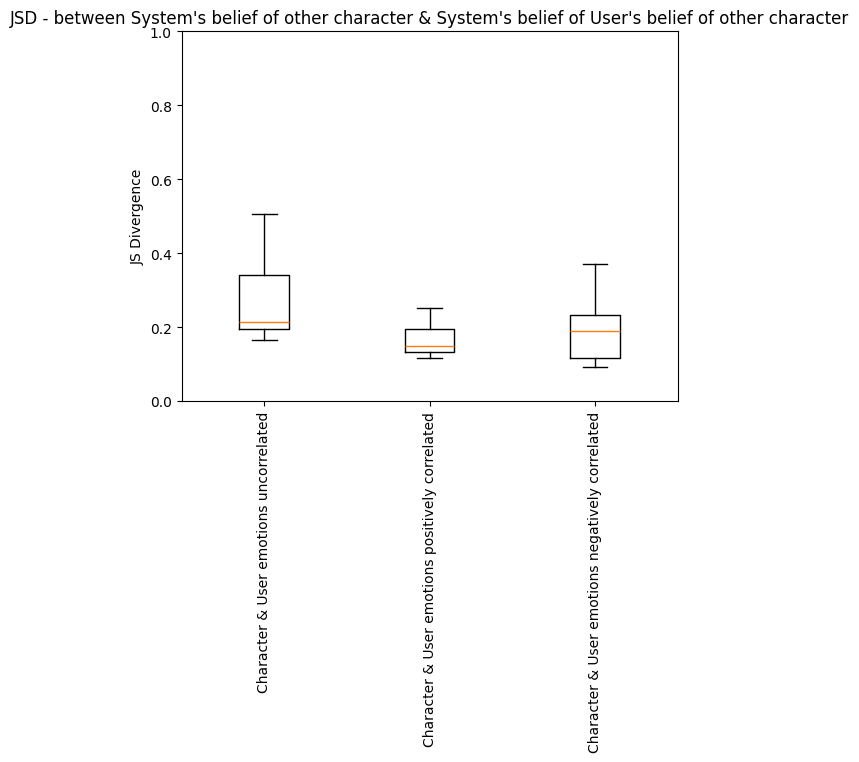

In [11]:
def show_aggregated_results_correlation(uncorrelated_test_case, pos_correlated_test_case, neg_correlated_test_case):
    labels = [
        'Character & User emotions uncorrelated', 'Character & User emotions positively correlated', 'Character & User emotions negatively correlated'
    ]

    # JSD - between System's belief of User & System's belief of other character
    plt.boxplot([
        uncorrelated_test_case.jsds_1_2,
        pos_correlated_test_case.jsds_1_2,
        neg_correlated_test_case.jsds_1_2,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of User & System's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()

    # JSD - between System's belief of User & System's belief of User's belief of other character
    plt.boxplot([
        uncorrelated_test_case.jsds_1_3,
        pos_correlated_test_case.jsds_1_3,
        neg_correlated_test_case.jsds_1_3,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of User & System's belief of User's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()

    # JSD - between System's belief of other character & System's belief of User's belief of other character
    plt.boxplot([
        uncorrelated_test_case.jsds_2_3,
        pos_correlated_test_case.jsds_2_3,
        neg_correlated_test_case.jsds_2_3,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of other character & System's belief of User's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()


show_aggregated_results_correlation(uncorrelated_test_case, pos_correlated_test_case, neg_correlated_test_case)


C:\Users\dchal\AppData\Local\Temp\ipykernel_25364\1204808950.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


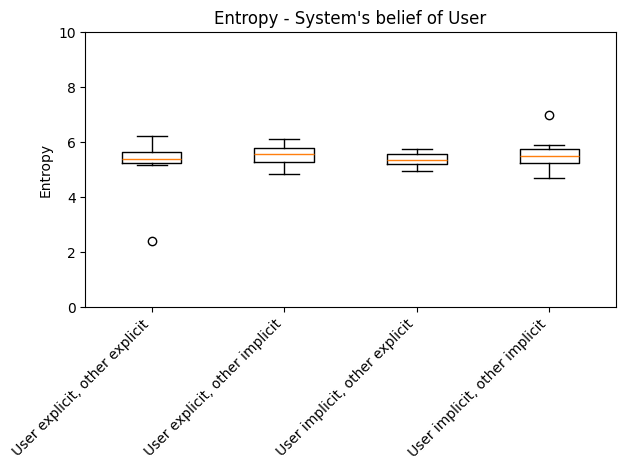

C:\Users\dchal\AppData\Local\Temp\ipykernel_25364\1204808950.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


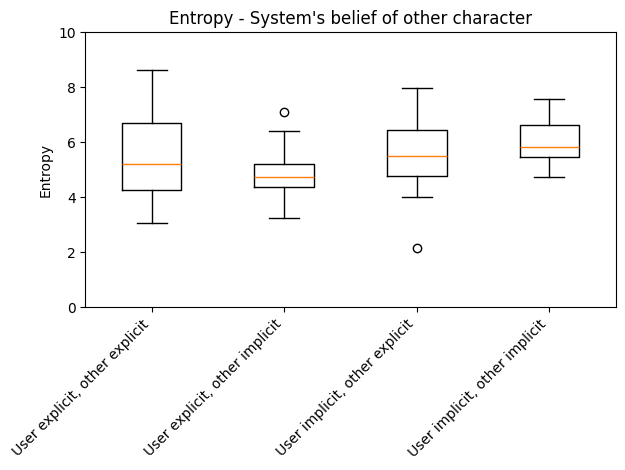

C:\Users\dchal\AppData\Local\Temp\ipykernel_25364\1204808950.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


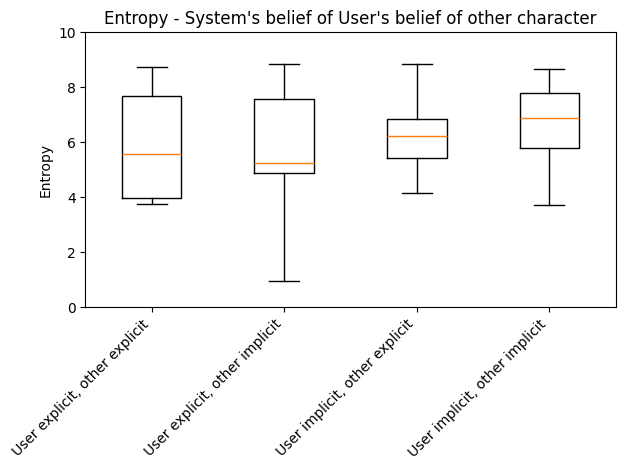

In [10]:
def show_aggregated_results_enotropy(user_exp_character_exp_test_case, user_exp_character_imp_test_case, user_imp_character_exp_test_case, user_imp_character_imp_test_case):
    labels = [
        "User explicit, other explicit",
        "User explicit, other implicit",
        "User implicit, other explicit",
        "User implicit, other implicit"
    ]

    # Entropy - System's belief of User
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_1,
        user_exp_character_imp_test_case.entropies_1,
        user_imp_character_exp_test_case.entropies_1,
        user_imp_character_imp_test_case.entropies_1,
    ], labels=labels)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of User")
    plt.ylim(0, 10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Entropy - System's belief of other character
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_2,
        user_exp_character_imp_test_case.entropies_2,
        user_imp_character_exp_test_case.entropies_2,
        user_imp_character_imp_test_case.entropies_2,
    ], labels=labels)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of other character")
    plt.ylim(0, 10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Entropy - System's belief of User's belief of other character
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_3,
        user_exp_character_imp_test_case.entropies_3,
        user_imp_character_exp_test_case.entropies_3,
        user_imp_character_imp_test_case.entropies_3,
    ], labels=labels)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of User's belief of other character")
    plt.ylim(0, 10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

show_aggregated_results_enotropy(user_exp_character_exp_test_case, user_exp_character_imp_test_case, user_imp_character_exp_test_case, user_imp_character_imp_test_case)